In [1]:
import numpy as np

from scipy.special import erfinv

from spitfire.chemistry.mechanism import ChemicalMechanismSpec
from spitfire import ChemicalMechanismSpec, Flamelet, build_adiabatic_slfm_library
import matplotlib.pyplot as plt
from numpy import linspace, zeros_like
from cantera import one_atm
from time import perf_counter as timer
import cantera as ct
import pickle

from PCASolv import preprocess_data, compute_TPY_source_terms, cantera_solution_array_from_state_vars


import plotly as plty
from plotly import express as px

from matplotlib import rcParams
rcParams['font.size'] = 12


In [2]:
canteraInput = "/Users/elizabeth/ChemicalMechanisms/h2-burke/h2-burke.xml"
m = ChemicalMechanismSpec(cantera_xml=canteraInput, group_name='h2-burke')


In [3]:
zstoich = 0.1
chiMaxVals = [1.e3]
npts_interior = 128

pressure = ct.one_atm
Tair = 1200.

air = m.stream(stp_air=True)
air.TP = Tair, pressure
fuel = m.mix_fuels_for_stoich_mixture_fraction(m.stream('X', 'H2:1'), m.stream('X', 'N2:1'), zstoich, air)

fuel.TP = 300., pressure

flamelet_specs = {'mech_spec': m,
#                   'pressure': pressure,
                  'initial_condition': 'equilibrium',
                  'oxy_stream': air,
                  'fuel_stream': fuel,
                  'grid_points': npts_interior + 2,
                  'include_enthalpy_flux': False,
                  'include_variable_cp': False}

z_st = m.stoich_mixture_fraction(fuel, air)


## Steady

In [4]:
chiMaxVals = np.concatenate([np.logspace(-0.7, 3.99,180), np.linspace(10**4, 10**5, 101)])

l_sl = build_adiabatic_slfm_library(flamelet_specs,
                                    diss_rate_values=chiMaxVals,
                                    diss_rate_ref='maximum',
                                    verbose=True)

nchi = l_sl.dissipation_rate_stoich_npts
print('max dissipation rate:',l_sl.dissipation_rate_stoich_grid.max())

----------------------------------------------------------------------------------
building adiabatic SLFM library
----------------------------------------------------------------------------------
- mechanism: /Users/elizabeth/ChemicalMechanisms/h2-burke/h2-burke.xml
- 11 species, 27 reactions
- stoichiometric mixture fraction: 0.100
----------------------------------------------------------------------------------
   1/ 281 (chi_max =  2.0e-01 1/s)  converged in   1.02 s, T_max = 2706.4
   2/ 281 (chi_max =  2.1e-01 1/s)  converged in   0.00 s, T_max = 2706.3
   3/ 281 (chi_max =  2.3e-01 1/s)  converged in   0.00 s, T_max = 2706.3
   4/ 281 (chi_max =  2.4e-01 1/s)  converged in   0.00 s, T_max = 2706.3
   5/ 281 (chi_max =  2.5e-01 1/s)  converged in   0.00 s, T_max = 2706.3
   6/ 281 (chi_max =  2.7e-01 1/s)  converged in   0.00 s, T_max = 2706.2
   7/ 281 (chi_max =  2.9e-01 1/s)  converged in   0.00 s, T_max = 2706.2
   8/ 281 (chi_max =  3.0e-01 1/s)  converged in   0.00 s, T_m

 106/ 281 (chi_max =  1.1e+02 1/s)  converged in   0.00 s, T_max = 2543.7
 107/ 281 (chi_max =  1.2e+02 1/s)  converged in   0.01 s, T_max = 2536.9
 108/ 281 (chi_max =  1.3e+02 1/s)  converged in   0.00 s, T_max = 2529.9
 109/ 281 (chi_max =  1.3e+02 1/s)  converged in   0.01 s, T_max = 2522.8
 110/ 281 (chi_max =  1.4e+02 1/s)  converged in   0.00 s, T_max = 2515.4
 111/ 281 (chi_max =  1.5e+02 1/s)  converged in   0.01 s, T_max = 2507.9
 112/ 281 (chi_max =  1.6e+02 1/s)  converged in   0.00 s, T_max = 2500.3
 113/ 281 (chi_max =  1.7e+02 1/s)  converged in   0.01 s, T_max = 2492.5
 114/ 281 (chi_max =  1.8e+02 1/s)  converged in   0.00 s, T_max = 2484.5
 115/ 281 (chi_max =  1.9e+02 1/s)  converged in   0.00 s, T_max = 2476.4
 116/ 281 (chi_max =  2.1e+02 1/s)  converged in   0.00 s, T_max = 2468.1
 117/ 281 (chi_max =  2.2e+02 1/s)  converged in   0.00 s, T_max = 2459.7
 118/ 281 (chi_max =  2.3e+02 1/s)  converged in   0.01 s, T_max = 2451.1
 119/ 281 (chi_max =  2.5e+02 1/s)  co

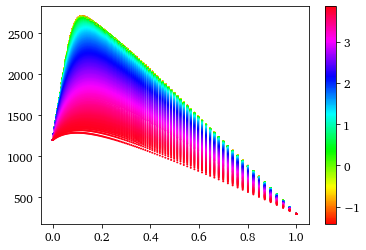

In [5]:

plt.scatter(l_sl.mixture_fraction_grid.flatten(), 
            l_sl['temperature'].flatten(),
            s=1,
            c=np.log10(l_sl.dissipation_rate_stoich_grid.flatten()),
            cmap=plt.cm.hsv)
plt.colorbar()
# plt.grid()
plt.show()


## Transient

In [6]:
flamelet_specs['stoich_dissipation_rate'] = 2*l_sl.dissipation_rate_stoich_values[-1]
flamelet_specs['library_slice'] = l_sl[:,-1]
f = Flamelet(**flamelet_specs)
l_t = f.integrate_to_steady(write_log=True, log_rate=30)
chi_max_t = flamelet_specs['stoich_dissipation_rate']*np.exp(2*erfinv(2*z_st-1)**2)
l_t['chi_max'] = chi_max_t*np.ones_like(l_t.mixture_fraction_grid)

### remove the first entry on transient library so do not have duplicate states with steady library above
l_t = l_t[1:,:]
l_t.shape



 2021-03-16 22:49 : Spitfire running case with method: Kennedy/Carpenter ESDIRK64

|number of  | simulation | time step  | diff. eqn. | total cpu  | cput per |
|time steps | time (s)   | size (s)   | |residual| | time (s)   | step (ms)|
---------------------------------------------------------------------------|
| 30        | 5.57e-06   | 2.43e-07   | 1.47e+04   | 2.65e-01   | 8.84e+00 |
| 60        | 1.65e-05   | 5.34e-07   | 4.04e+03   | 5.36e-01   | 8.93e+00 |
| 90        | 3.55e-05   | 7.39e-07   | 2.50e+02   | 8.37e-01   | 9.30e+00 |
| 120       | 8.36e-05   | 3.95e-06   | 4.31e-02   | 1.07e+00   | 8.94e+00 |

Integration successfully completed!

Statistics:
- number of time steps : 127
- final simulation time: 0.00012330514519769852
- smallest time step   : 8.692654526996095e-08
- average time step    : 9.709066550999884e-07
- largest time step    : 7.00338044543888e-06

  CPU time
- total    (s) : 1.134292e+00
- per step (ms): 8.931434e+00

  Nonlinear iterations
- total   : 30

(127, 130)

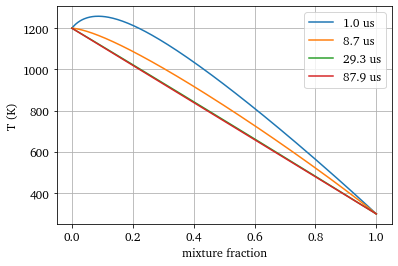

In [7]:
for it in range(0, l_t.time_npts, 40):
    plt.plot(l_t.mixture_fraction_values,
             l_t['temperature'][it, :].T,
             label=f'{l_t.time_values[it]*1.e6:.1f} us')
plt.ylabel('T (K)')
plt.xlabel('mixture fraction')
plt.legend(loc='best')
plt.grid()
plt.show()


## Saving data

In [8]:

class FlameletData:
    def __init__(self, canteraInput, flameletOutputList, zStoichList):
        
        assert(len(flameletOutputList) == len(zStoichList))
        
        self.canteraInput   = canteraInput
        self.nObs           = 0
        self.chiMax         = []
        self.mixureFraction = []
        
        oldNames = flameletOutputList[0].props
        new2OldName = {}
        
        for oldName in oldNames:
            if   oldName is "pressure"       : newName = "P"
            elif oldName is "temperature"    : newName = "T"
            elif "mass fraction " in oldName : newName = oldName.split("mass fraction ")[1]
            else: raise RuntimeError('unhandled name: ' + oldName)
                
            new2OldName[newName] = oldName
        
        
        self.props = {name : [] for name in new2OldName.keys()}
    
        
        for out, zStoich in zip(flameletOutputList, zStoichList):
            stoich2max = np.exp(2*erfinv(2*zStoich-1)**2)
            self.chiMax        .append(out.dissipation_rate_stoich_grid.ravel()*stoich2max)
            self.mixureFraction.append(out.mixture_fraction_grid       .ravel()           )

            for key, val in self.props.items():
                oldName = new2OldName[key]
                val.append(out[oldName].ravel())

        self.chiMax         = (np.concatenate(self.chiMax        )[np.newaxis]).T
        self.mixureFraction = (np.concatenate(self.mixureFraction)[np.newaxis]).T
        
        self.nObs = self.chiMax.size
    
        for key, val in self.props.items():
            self.props[key] = (np.concatenate(val)[np.newaxis]).T
        
    
    def get_TPY_state_space_matrix(self, nth_species='N2'):
        '''
        constructs and returns state space matrix consisting of temperature, pressure,
        and species mass fractions, as well as a list of variable names. Each column represents
        A state variable and row an observation.
        '''
        
        varNames = list(self.props.keys())
        varNames.remove(nth_species)
        
        state = np.hstack([self.props[name] for name in varNames])
        
        return state, varNames
    
    

def get_flamelet_diffusivities(stateVars, 
                               varNames, 
                               mixtureFraction, 
                               chiMax, 
                               canteraInput,
                               nth_species='N2'):
    
    gas = cantera_solution_array_from_state_vars(stateVars, varNames, canteraInput, nth_species)
    
    zClipped = np.clip(mixtureFraction,0.0001, 0.9999)        
    chi      = np.squeeze(chiMax*np.exp(-2*erfinv(2*zClipped-1)**2))
    
    D_Yi = chi/2
    D_T  = np.squeeze(gas.cp_mass)*chi/2
    D_P  = 0

#     varNames.remove(nth_species)

    nObs, nVars = stateVars.shape
    diffCoeffs = np.ndarray([nObs, nVars])

    for i, name in enumerate(varNames):
        if name is 'T':
            diffCoeffs[:,i] = D_T
        elif name is 'P':
            diffCoeffs[:,i] = D_P
        else:
            diffCoeffs[:,i] = D_Yi

    return diffCoeffs
    
    

### starting with steady flamelet, varying scalar dissipation rate

In [9]:
fd = FlameletData(canteraInput,[l_sl], [z_st])
X, names = fd.get_TPY_state_space_matrix()
S_X = compute_TPY_source_terms(X, names, canteraInput)
# D_X = get_flamelet_diffusivities(X, names, fd.mixureFraction, fd.chiMax, canteraInput)

### set pure stream source terms to zero
S_X[:nchi,:] = 0.0
S_X[-nchi:,:] = 0.0


### computing transient

In [10]:
X_transient = np.zeros(len(names))
for n in names:
    if n=='T':
        X_transient = l_t['temperature'].T.ravel()
    elif n=='P':
        X_transient = np.vstack((X_transient, l_t['pressure'].T.ravel()))
    else:
        X_transient = np.vstack((X_transient, l_t['mass fraction '+n].T.ravel()))
X_transient = X_transient.T
S_X_transient = compute_TPY_source_terms(X_transient, names, canteraInput)

### set pure stream source terms to zero
S_X_transient[:l_t.time_npts,:] = 0.0
S_X_transient[-l_t.time_npts:,:] = 0.0


### concatenating datasets

In [20]:
include_transient = True

varsDict = \
{'mixture_fraction':fd.mixureFraction.ravel(),
'chi_max':fd.chiMax.ravel()}

srcDict          = {}
# diffusivityfDict = {}
for i,name in enumerate(names):
    varsDict         [name] = X  [:,i].ravel()
    srcDict          [name] = S_X[:,i].ravel()
#     diffusivityfDict [name] = D_X[:,i].ravel()


if include_transient:
    varsDict['mixture_fraction'] = np.hstack((varsDict['mixture_fraction'], l_t.mixture_fraction_grid.T.ravel()))
    varsDict['chi_max'] = np.hstack((varsDict['chi_max'], l_t['chi_max'].T.ravel()))
    for i,name in enumerate(names):
        varsDict[name] = np.hstack(( varsDict[name], X_transient[:,i].ravel()))
        srcDict[name]  = np.hstack(( srcDict[name], S_X_transient[:,i].ravel()))
        

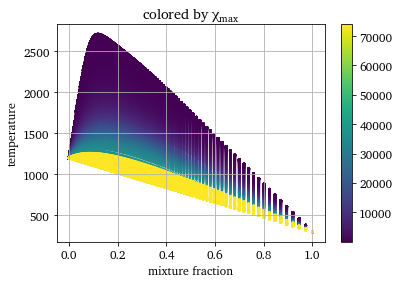

In [21]:
plt.scatter(varsDict['mixture_fraction'], varsDict['T'],c=varsDict['chi_max'],s=3)
plt.colorbar()
plt.xlabel('mixture fraction')
plt.ylabel('temperature')
plt.title('colored by $\chi_{max}$')
plt.grid()
plt.show()


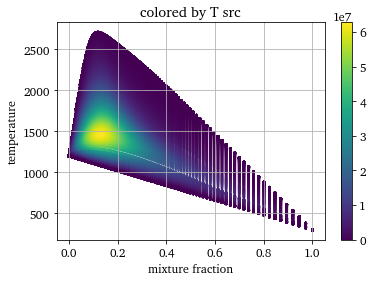

In [22]:
plt.scatter(varsDict['mixture_fraction'], varsDict['T'], c=srcDict['T'],s=3)
plt.colorbar()
plt.xlabel('mixture fraction')
plt.ylabel('temperature')
plt.grid()
plt.title('colored by T src')
plt.show()


### saving result

In [23]:
resave = False

if resave:
    pickle.dump(varsDict        , open('transient-H2-air-flamelet-vars.p','wb'))
    pickle.dump(srcDict         , open('transient-H2-air-flamelet-source-terms.p','wb'))
    # pickle.dump(diffusivityfDict, open('transient-H2-air-flamelet-diffusivities.p','wb'))
